# Convergence

No handles with labels found to put in legend.


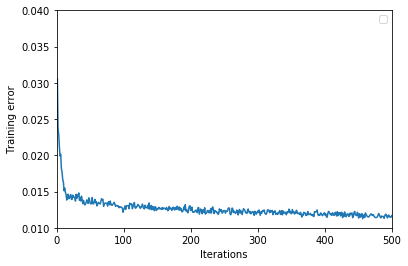

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import src.utils as utils
import pickle
root_folder = '/data/LiftFly3D/fly_ventral_lowres/network/'

epoch, lr, loss_train, loss_test, err_test = utils.read_convergence_info(root_folder +'log_train.txt')
plt.plot(np.array(err_test)*15/1700)
    
plt.xlim([0, 500])
plt.ylim([0.01,0.04])
plt.ylabel('Training error')
plt.xlabel('Iterations')
plt.legend()
#plt.savefig('test_error.svg')

# Joint angles

In [2]:
import torch
import numpy as np
from numpy import matlib
import matplotlib.pyplot as plt
from skeleton import skeleton
import src.utils as utils
G, color_edge = skeleton()

In [46]:
def pts3d_to_angle(pts3d,G):
    '''compute joint angles from DeepFly3D'''
    
    n = int(len(G.nodes))
    j_angles = np.zeros((pts3d.shape[0], n), dtype=np.float32)
    err_j_angles = np.zeros((pts3d.shape[0], n), dtype=np.float32)
    
    for j in range(0, n): #joint
        if G.degree(j) == 1:
            nb = [n for n in G.neighbors(j)]
            if nb[0]>j:
                x0 = pts3d[:, j, :] + matlib.repmat(np.array([1,0,0]), pts3d.shape[0], 1)
                j_angles[:, j], err_j_angles[:, j] = cos_rule(pts3d[:, nb[0], :], pts3d[:, j, :], x0)
        
        if G.degree(j) == 2:    
            nb = [n for n in G.neighbors(j)]
            if (nb[0]<j) and (nb[1]>j):
                j_angles[:, j], err_j_angles[:, j] = cos_rule(pts3d[:, nb[0], :], pts3d[:, j, :], pts3d[:, nb[1], :])
            
    j_angles[np.logical_or(np.isnan(j_angles), np.isinf(j_angles))] = 0

    return j_angles, err_j_angles


def cos_rule(a, b, c):
    '''cos-rule between angle spanned by 3 points'''
    
    ba = a - b
    bc = c - b
    
    normba = np.linalg.norm(ba, axis=1)
    normbc = np.linalg.norm(bc, axis=1)
    
    stdba = np.std(normba)
    stdbc = np.std(normbc)
    
    cos_angle = []
    for i in range(5000):
        randa = np.random.normal(loc=0.0, scale=stdba)
        randb = np.random.normal(loc=0.0, scale=stdbc)
        
        if len(np.where(ba==0)[0])>0:
            xa = np.sqrt(stdba**2/2)
            xc = np.sqrt(stdbc**2/2)
            randba = np.random.multivariate_normal([0,0,0], [[xa,0,0],[0,xa,0],[0,0,0]])
            randbc = np.random.multivariate_normal([0,0,0], [[xc,0,0],[0,xc,0],[0,0,0]])
        else:
            xa = np.sqrt(stdba**2/3)
            xc = np.sqrt(stdbc**2/3)
            randba = np.random.multivariate_normal([0,0,0], [[xa,0,0],[0,xa,0],[0,0,xa]])
            randbc = np.random.multivariate_normal([0,0,0], [[xc,0,0],[0,xc,0],[0,0,xc]])

        dotbabc = np.einsum("ij,ij->i", ba+randba, bc+randbc)
        
        cos_angle.append(dotbabc / ((normba+randa) * (normbc+randb)))
        
    cos_angle = np.vstack(cos_angle)
    
    if (np.abs(cos_angle)>1).any():
        cos_angle[np.abs(cos_angle)>1] = 0
        print('some values outside [-1, 1] are detected')
        
    angle = np.arccos(cos_angle)
        
    angle_mean = np.mean(angle,axis=0)
    angle_err = np.std(angle,axis=0)/2
    
    return angle_mean, angle_err


def plot_epoch(tint, time, j_angles, err_j_angles, joints, title, ylim, ax, ylabel=None, label=None,col='r'):
    ax.set_title(title, fontsize=20)
    
    for j in joints:
        if label is not None:
            ax.plot(time, j_angles[:,j], col, label=label)
        else:
            ax.plot(time, j_angles[:,j], col)
        ax.fill_between(time, j_angles[:,j] - err_j_angles[:,j] , j_angles[:,j] + err_j_angles[:,j], alpha=0.3, color=col)
        
    ax.set_xlim(tint) 
    ax.set_ylim(ylim)
    ax.set_ylabel(ylabel, fontsize=15)
    ax.set_ylabel(ylabel, fontsize=15)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(15)
        
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(15)
    
    return ax

Load data and rescale

In [26]:
data_dir = '/data/LiftFly3D/fly_ventral_lowres/102906_s1a5_p6-0'
template_dir = '/data/LiftFly3D/fly_ventral_lowres/network/'
        
#load predictions
data = torch.load(data_dir + '/test_results.pth.tar')
out = data['output']
inp = data['input']

#output
targets_1d = torch.load(data_dir + '/stat_3d.pth.tar')['targets_1d']
test_keypts = torch.load(data_dir + '/stat_3d.pth.tar')['LR_test']
test_keypts = np.concatenate([v for k,v in test_keypts.items()], 0)
out_mean = torch.load(data_dir + '/stat_3d.pth.tar')['mean']
out_std = torch.load(data_dir + '/stat_3d.pth.tar')['std']
offset = torch.load(data_dir + '/stat_3d.pth.tar')['offset']
offset = np.concatenate([v for k,v in offset.items()], 0)
targets_1d = torch.load(data_dir + '/stat_3d.pth.tar')['targets_1d'] 
out = utils.expand(out,targets_1d,len(out_mean))
out = utils.unNormalizeData(out, out_mean, out_std)
out += np.hstack((offset[0,15:],offset[0,15:]))

#out = utils.filter_data(out, window=7, order=3)

#inputs
targets_2d = torch.load(template_dir + '/stat_2d.pth.tar')['targets_2d']    
inp_mean = torch.load(template_dir + 'stat_2d.pth.tar')['mean']
inp_std = torch.load(template_dir + 'stat_2d.pth.tar')['std']
targets_2d = torch.load(template_dir + '/stat_2d.pth.tar')['targets_2d'] 
inp = utils.expand(inp,targets_2d,len(inp_mean))
inp = utils.unNormalizeData(inp, inp_mean, inp_std)

inp /= 112
out /= 112
poses = np.stack((inp[:,::2],inp[:,1::2],out), axis=2)

Projected traces

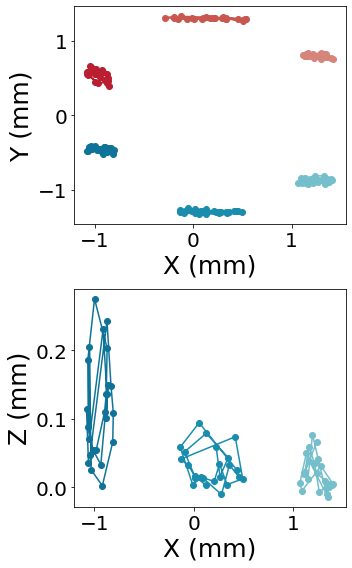

In [34]:
tint = [19.2,19.5]

fig = plt.figure(figsize=([5,8])) 
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

tint = np.array(tint)
tint *= 80
tint = tint.astype(int)
times = np.arange(tint[0],tint[1])

for i in [4,9,14,19,24,29]:
    ax1.plot(poses[times,i,0],poses[times,i,1],'-o', c=color_edge[i]) 
       
for j, i in enumerate([4,9,14]): #plot projected tarsus coordinates
    ax2.plot(poses[times,i,0],poses[times,i,2]+[0.08,0.1,0.13][j],'-o', c=color_edge[i])
        
ax1.set_xlabel('X (mm)', fontsize=25)
ax1.set_ylabel('Y (mm)', fontsize=25)
ax2.set_xlabel('X (mm)', fontsize=25)
ax2.set_ylabel('Z (mm)', fontsize=25)
#ax1.axis('square')
#ax1.set_xlim([-2, 2])
#ax1.set_ylim([-2, 2])
#ax2.set_ylim([-0.4, 0])
#ax2.set_xlim([-2, 2])
plt.tight_layout()
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)
plt.savefig('projections.svg')

Physical angles

some values outside [-1, 1] are detected
some values outside [-1, 1] are detected
some values outside [-1, 1] are detected
some values outside [-1, 1] are detected
some values outside [-1, 1] are detected
some values outside [-1, 1] are detected
some values outside [-1, 1] are detected
some values outside [-1, 1] are detected
some values outside [-1, 1] are detected
some values outside [-1, 1] are detected
some values outside [-1, 1] are detected
some values outside [-1, 1] are detected
some values outside [-1, 1] are detected
some values outside [-1, 1] are detected
some values outside [-1, 1] are detected
some values outside [-1, 1] are detected
some values outside [-1, 1] are detected
some values outside [-1, 1] are detected
some values outside [-1, 1] are detected
some values outside [-1, 1] are detected
some values outside [-1, 1] are detected
some values outside [-1, 1] are detected
some values outside [-1, 1] are detected
some values outside [-1, 1] are detected
some values outs

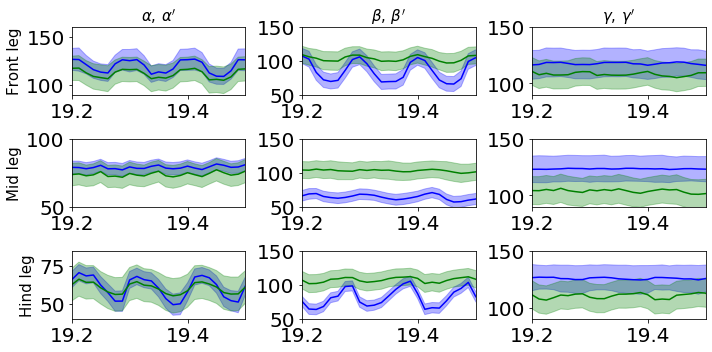

In [39]:
f, axs = plt.subplots(3, 3, figsize=(10,5))

tint = [19.2,19.5]
def plot_angles(time, poses, tint, proj=False, LR=False, col=None):
    
    poses_copy = poses.copy()
    
    if proj:
        poses_copy[:,:,2::3] = 0
        
    if col is None:
        col = 'b'
    
    j_angles, err_j_angles = pts3d_to_angle(poses_copy,G)
    j_angles = np.degrees(j_angles)
    err_j_angles = np.degrees(err_j_angles)
           
    #front legs
    axs[0,0] = plot_epoch(tint, time, j_angles, err_j_angles, [1], r'$\alpha,\,\alpha^\prime$', [90,160], axs[0,0], ylabel='Front leg', label="Left",col=col)
    axs[0,1] = plot_epoch(tint, time, j_angles, err_j_angles, [2], r'$\beta,\,\beta^\prime$', [50,150], axs[0,1],col=col)
    axs[0,2] = plot_epoch(tint, time, j_angles, err_j_angles, [3], r'$\gamma,\,\gamma^\prime$', [90, 150], axs[0,2],col=col)

    #midlegs
    axs[1,0] = plot_epoch(tint, time, j_angles, err_j_angles, [6], '', [50, 100], axs[1,0], ylabel='Mid leg',col=col)
    axs[1,1] = plot_epoch(tint, time, j_angles, err_j_angles, [7], '', [50, 150], axs[1,1],col=col)
    axs[1,2] = plot_epoch(tint, time, j_angles, err_j_angles, [8], '', [90, 150], axs[1,2],col=col)
    
    #hindlegs
    axs[2,0] = plot_epoch(tint, time, j_angles, err_j_angles, [11], '', [40, 85], axs[2,0], ylabel='Hind leg',col=col)
    axs[2,1] = plot_epoch(tint, time, j_angles, err_j_angles, [12], '', [50, 150], axs[2,1],col=col)
    axs[2,2] = plot_epoch(tint, time, j_angles, err_j_angles, [13], '', [90, 150], axs[2,2],col=col)
    
    if LR:
        axs[0,0] = plot_epoch(tint, time, j_angles, err_j_angles, [16], r'$\alpha,\,\alpha^\prime$', [50,150], axs[0,0],  ylabel='Front leg', label="Right",col='r')
        axs[0,1] = plot_epoch(tint, time, j_angles, err_j_angles, [17], r'$\beta,\,\beta^\prime$', [50,150], axs[0,1],col='r')
        axs[0,2] = plot_epoch(tint, time, j_angles, err_j_angles, [18], r'$\gamma,\,\gamma^\prime$', [50, 150], axs[0,2],col='r')
        
        axs[1,0] = plot_epoch(tint, time, j_angles, err_j_angles, [21], '', [50, 100], axs[1,0], ylabel='Mid leg',col='r')
        axs[1,1] = plot_epoch(tint, time, j_angles, err_j_angles, [22], '', [50, 150], axs[1,1],col='r')
        axs[1,2] = plot_epoch(tint, time, j_angles, err_j_angles, [23], '', [50, 150], axs[1,2],col='r')
        
        axs[2,0] = plot_epoch(tint, time, j_angles, err_j_angles, [26], '', [50, 100], axs[2,0], ylabel='Hind leg',col='r')
        axs[2,1] = plot_epoch(tint, time, j_angles, err_j_angles, [27], '', [50, 150], axs[2,1],col='r')
        axs[2,2] = plot_epoch(tint, time, j_angles, err_j_angles, [28], '', [50, 150], axs[2,2],col='r')
        
    return axs
    
freq = 1/80
time = np.arange(poses.shape[0])*freq
    
plot_angles(time, poses, tint)
plot_angles(time, poses, tint, proj=True, col='g')
plt.tight_layout()
#plt.savefig('joint_angles.svg')

# Video

Joint angles

some values outside [-1, 1] are detected
some values outside [-1, 1] are detected
some values outside [-1, 1] are detected
some values outside [-1, 1] are detected
some values outside [-1, 1] are detected
some values outside [-1, 1] are detected
some values outside [-1, 1] are detected
some values outside [-1, 1] are detected
some values outside [-1, 1] are detected
some values outside [-1, 1] are detected
some values outside [-1, 1] are detected
some values outside [-1, 1] are detected
some values outside [-1, 1] are detected
some values outside [-1, 1] are detected
some values outside [-1, 1] are detected
some values outside [-1, 1] are detected
some values outside [-1, 1] are detected
some values outside [-1, 1] are detected
some values outside [-1, 1] are detected
some values outside [-1, 1] are detected
some values outside [-1, 1] are detected
some values outside [-1, 1] are detected
some values outside [-1, 1] are detected
some values outside [-1, 1] are detected
some values outs

  0%|          | 0/2399 [00:00<?, ?it/s]

some values outside [-1, 1] are detected


100%|██████████| 2399/2399 [04:13<00:00,  9.47it/s]


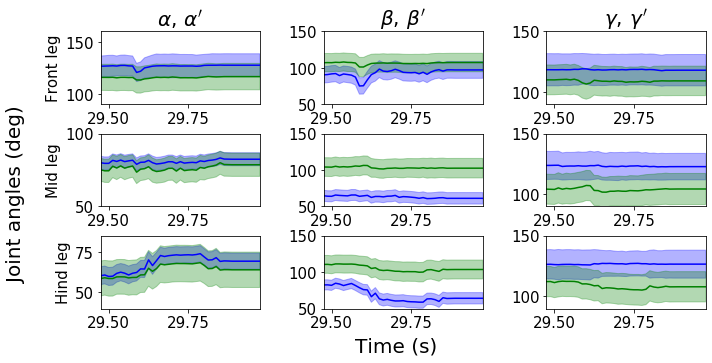

In [47]:
from matplotlib.animation import FFMpegWriter
from tqdm import tqdm
f, axs = plt.subplots(3, 3, figsize=(10,5))
f.subplots_adjust(left=0.14, bottom=0.13, right=0.98, top=0.90, wspace=0.4, hspace=0.4)
nframes = 2399
freq = 1/80
w = 80
time = np.arange(poses.shape[0])*freq 
axs = plot_angles(time, poses, [time[0], time[w]])
axs = plot_angles(time, poses, [time[0], time[w]], proj=True, col='g')

f.text(0.55, 0.01, 'Time (s)', ha='center', fontsize=20)
f.text(0.01, 0.45, 'Joint angles (deg)', va='center', rotation='vertical', fontsize=20)
#handles, labels = axs[0,0].get_legend_handles_labels()
#f.legend(handles, loc='upper center')
#axs[0,0].legend(loc=(0.1,1.5), frameon=True, ncol=2, fontsize=15)

for item in [f, ax]:
    item.patch.set_visible(False)

writer = FFMpegWriter(fps=10)
l={}
with writer.saving(f, "joint_angles.mp4", 100):
    for t in tqdm(range(nframes)):
        
        if t-w//2<0:
            tint = [time[0], time[w]]
        elif t+w//2>=nframes:
            tint = [time[t-w//2], time[t]]
        else:
            tint = [time[t-w//2], time[t+w//2]]
                 
        axs[0,0].set_xlim(tint)
        axs[0,1].set_xlim(tint)
        axs[0,2].set_xlim(tint)
        axs[1,0].set_xlim(tint)
        axs[1,1].set_xlim(tint)
        axs[1,2].set_xlim(tint)
        axs[2,0].set_xlim(tint)
        axs[2,1].set_xlim(tint)
        axs[2,2].set_xlim(tint)
          
        l[0] = axs[0,0].axvline(x=time[t], ymin=0, ymax=1, color='r')
        l[1] = axs[0,1].axvline(x=time[t], ymin=0, ymax=1, color='r')
        l[2] = axs[0,2].axvline(x=time[t], ymin=0, ymax=1, color='r')
        l[3] = axs[2,2].axvline(x=time[t], ymin=0, ymax=1, color='r')
        l[4] = axs[1,0].axvline(x=time[t], ymin=0, ymax=1, color='r')
        l[5] = axs[2,0].axvline(x=time[t], ymin=0, ymax=1, color='r')
        l[6] = axs[1,1].axvline(x=time[t], ymin=0, ymax=1, color='r')
        l[7] = axs[1,2].axvline(x=time[t], ymin=0, ymax=1, color='r')
        l[8] = axs[2,1].axvline(x=time[t], ymin=0, ymax=1, color='r')
        
        #plt.text(120, 80, str(i), fontsize=50, color='white')

        writer.grab_frame()
        l[0].remove()
        l[1].remove()
        l[2].remove()
        l[3].remove()
        l[4].remove()
        l[5].remove()
        l[6].remove()
        l[7].remove()
        l[8].remove()


Projected traces

100%|██████████| 2399/2399 [00:49<00:00, 48.26it/s]


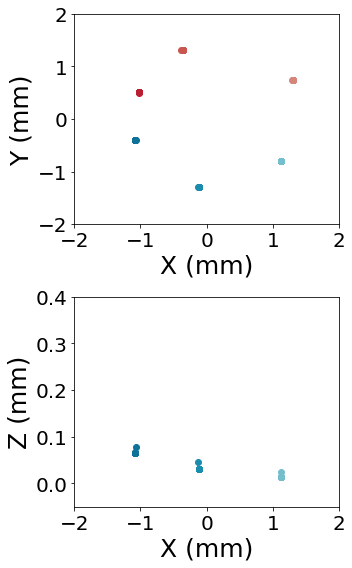

In [35]:
from matplotlib.animation import FFMpegWriter
from tqdm import tqdm

nframes = 2399
w = 10

fig = plt.figure(figsize=([5,8])) 
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

times = np.arange(0,w)

l = {}
count = 0
for i in [4,9,14,19,24,29]:
    l[count], = ax1.plot(poses[times,i,0], poses[times,i,1],'-o', color=color_edge[i]) 
    count+=1
       
for i in [4,9,14]: #plot projected tarsus coordinates
    l[count], = ax2.plot(poses[times,i,0], poses[times,i,2]+[0.08,0.1,0.13][j],'-o', color=color_edge[i])
    count+=1

ax1.set_xlabel('X (mm)', fontsize=25)
ax1.set_ylabel('Y (mm)', fontsize=25)
ax2.set_xlabel('X (mm)', fontsize=25)
ax2.set_ylabel('Z (mm)', fontsize=25)
ax1.set_xlim([-2, 2])
ax1.set_ylim([-2, 2])
ax2.set_ylim([-0.05, 0.4])
ax2.set_xlim([-2, 2])
plt.tight_layout()
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)

writer = FFMpegWriter(fps=10)
with writer.saving(fig, "projected_traces.mp4", 50):
    for t in tqdm(range(nframes)):
        
        if t-w<0:
            tint = [0, w]
        else:
            tint = [t-w, t]
            
        times = np.arange(tint[0], tint[1])
            
        count = 0
        for i in [4,9,14,19,24,29]:
            l[count].set_xdata(poses[times,i,0])
            l[count].set_ydata(poses[times,i,1])
            count+=1
            
        for j,i in enumerate([4,9,14]):
            l[count].set_xdata(poses[times,i,0])
            l[count].set_ydata(poses[times,i,2]+[0.08,0.1,0.13][j])
            count+=1
              
        writer.grab_frame()

# Merge videos

In [ ]:
#stack videos horizontally (call this in the folder where the images are)

#ffmpeg -i arena_marked.mp4 -i DLC_prediction.mp4 -filter_complex "[0:v]scale=-1:600[v0];[v0][1:v]hstack=inputs=2" output.mp4
#ffmpeg -i output.mp4 -i LiftPose3D_prediction.mp4 -filter_complex "[0:v]scale=-1:480[v0];[v0][1:v]hstack=inputs=2" output_2.mp4
#ffmpeg -i output_2.mp4 -i projected_traces.mp4 -filter_complex "[0:v]scale=-1:400[v0];[v0][1:v]hstack=inputs=2" output_3.mp4

#ffmpeg -i legend.mp4 -i joint_angles.mp4 -filter_complex "[0:v]scale=-1:500,pad='iw+mod(iw\,2)':'ih+mod(ih\,2)'[v0];[v0][1:v]hstack=inputs=2" output_4.mp4
#ffmpeg -i output_3.mp4 -i output_4.mp4 -filter_complex "[0:v]scale=1326:-1,pad='iw+mod(iw\,2)':'ih+mod(ih\,2)'[v0];[v0][1:v]vstack=inputs=2" video_3.mp4
